# Resonator Training

This notebook shows the process to train a resonator network to get the best weights and biases
* All of this code already implemented as part of the sctn package, notebook add interactive charts to follow the learning process.  

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sctn.layers import SCTNLayer
from sctn.spiking_network import SpikingNetwork
from sctn.spiking_neuron import create_SCTN, IDENTITY
from sctn.resonator import freq_of_resonator, lp_by_lf

clk_freq = 1536000
freq0 = 104
lf = 4
best_lp = lp_by_lf(lf, freq0, clk_freq)

print(f'Resonator with clock frequency of {clk_freq} Hz that react to {freq0} Hz, the resonator leakage parameters are LF = {lf} and LP = {best_lp}')

Resonator with clock frequency of 1536000 Hz that react to 104 Hz, the resonator leakage parameters are LF = 4 and LP = 145


In [2]:
# util functions

def neuron_output(neuron, signal_freq, shift_degrees=0, phase_number=10):
    y_events = neuron.out_spikes()
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > ((phase_number-1)/signal_freq) * clk_freq + shift_samples) &
        (y_events < ((phase_number/signal_freq) * clk_freq) + shift_samples)
    ]
    if len(y_events) == 0:
        return y_events
    return y_events

def events_to_spikes(events, run_window=0, spikes_arr_size=-1):
    if spikes_arr_size == -1:
        y_spikes = np.zeros(events[-1] + 1)
    else:
        y_spikes = np.zeros(spikes_arr_size)

    y_spikes[events] = 1
    if run_window == 0:
        return y_spikes

    y_spikes_rollsum = np.convolve(y_spikes, np.ones(run_window, dtype=int), 'valid')
    return y_spikes_rollsum

def amplify_spikes(base_spikes, spikes_window, base_min, base_max, amplify):
    base_spikes = events_to_spikes(base_spikes-resonator_input[0], spikes_arr_size=int(clk_freq/freq0)+1)
    result = np.zeros_like(base_spikes)
    result[np.arange(len(base_spikes)) % 2 == 1] = 1
    dc = (base_max + base_min)/2
    for i in range(spikes_window, len(result), spikes_window):
        slice_spikes = base_spikes[i:i+spikes_window]
        if len(slice_spikes) < spikes_window:
            break
        curr_spikes = np.sum(slice_spikes) - dc
        new_spikes = int(curr_spikes * amplify)

        if new_spikes > 0:
            spikes_ts = np.linspace(0, spikes_window, new_spikes).astype(int)//2*2 + i
            result[spikes_ts] = 1
        else:
            spikes_ts = np.linspace(0, spikes_window, abs(new_spikes)).astype(int)//2*2 - 1 + i
            result[spikes_ts] = 0
    result = np.where(result == 1)[0]
    return result

def smooth(arr, size):
    filter = np.exp(-(np.arange(size) - size//2)**2 / (2 * (size/4)**2))
    normalized_filter = filter / np.sum(filter)
    res = np.convolve(arr, normalized_filter, 'same')
    res[:size] = arr[:size]
    res[-size:] = arr[-size:]
    return res


def simple_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork()
    network.add_amplitude(1000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[0]
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[1+i]
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

def learning_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
        ground_truths,
        A,
        time_to_learn,
        max_weight,
        min_weight,
):
    network = simple_resonator(freq0, clk_freq, lf, thetas, weights)
    tau = clk_freq * time_to_learn / 2
    network.neurons[1].set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truths[0])
    for i in range(3):
        network.neurons[2+i].set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truths[1 + i])
    return network

def flat_weights(resonator):
    ws = []
    for neuron in resonator.neurons[1:]:
        for w in neuron.synapses_weights:
            ws.append(abs(float(f'{w:.3f}')))
    return np.array(ws)

def flat_thetas(resonator):
    return [float(f'{neuron.theta:.3f}') for neuron in resonator.neurons[1:]]

def argmax(arr):
    return .5 * (np.argmax(arr) + len(arr) - np.argmax(arr[::-1]) - 1)

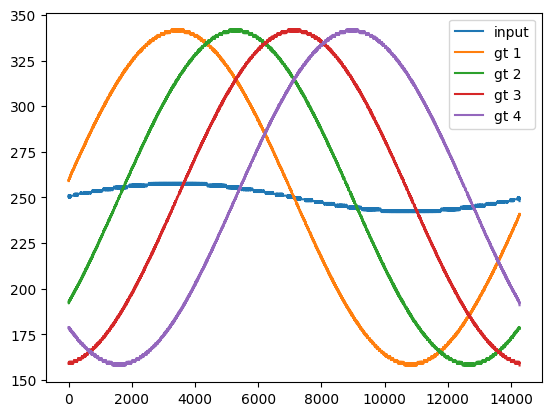

In [3]:
# generate ground truth

%matplotlib inline

gain = 12
duration = 15 / freq0
x = np.linspace(0, duration, int(duration * clk_freq))
t = x * 2 * np.pi * freq0
sine_wave = np.sin(t)

spikes_window = 500
resonator = SpikingNetwork()
resonator.add_amplitude(1000)

# Encode to pdm
neuron = create_SCTN()
neuron.activation_function = IDENTITY
resonator.add_layer(SCTNLayer([neuron]))

wave_length = int(clk_freq/freq0)
resonator.log_out_spikes(-1)
resonator.input_full_data(sine_wave)

resonator_input = neuron_output(resonator.neurons[0], freq0, shift_degrees=0)
rresonator_input = events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1)

ground_truth = []
# phase_shifts = [22.5, 67.5, 112.5, 157.5]
# phase_shifts = [22.5] + [45]*3
phase_shifts = [0] + [45]*3
phase_shifts = np.cumsum(phase_shifts)
for phase_shift in phase_shifts:
    phase_shift /= 360
    resonator.input_full_data(sine_wave[int((1-phase_shift)*wave_length):int((20-phase_shift)*wave_length)])
    resonator.log_out_spikes(-1)
    resonator.forget_logs()

    resonator.input_full_data(gain*sine_wave[int((1-phase_shift)*wave_length):])
    ground_truth.append(neuron_output(resonator.neurons[0], freq0))

gt1 = ground_truth[0]
gt2 = ground_truth[1]
gt3 = ground_truth[2]
gt4 = ground_truth[3]
rolling_gt = []
plt.plot(rresonator_input, label=f'input')
for i, gt in enumerate(ground_truth):
    rolling_gt.append(events_to_spikes(gt-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1))
    plt.plot(rolling_gt[i], label=f'gt {i+1}')

gt_wave_amplitudes = [(o.max(), o.min()) for o in rolling_gt]

plt.legend()
plt.show()

In [4]:
# init point of the resonator,
# As a rule of thumb for good init point:
#   b_0 = -(w_0 - w_1)/2
#   b_i = -w_(i+1) /2

chosen_bias=[-2, -10, -10, -10]
chosen_weights=[21, 17, 20, 20, 20]

In [7]:
resonator = learning_resonator(
    freq0=freq0,
    clk_freq=clk_freq,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
    ground_truths=ground_truth,
    A=2e-4,
    time_to_learn=1e-5,
    max_weight=np.inf,
    min_weight=-np.inf,
)
learning_rules = [neuron.supervised_stdp for neuron in resonator.neurons[1:]]
for i, neuron in enumerate(resonator.neurons):
    resonator.log_out_spikes(i)
    neuron.supervised_stdp = None

momentum_beta = .0

<IPython.core.display.Javascript object>


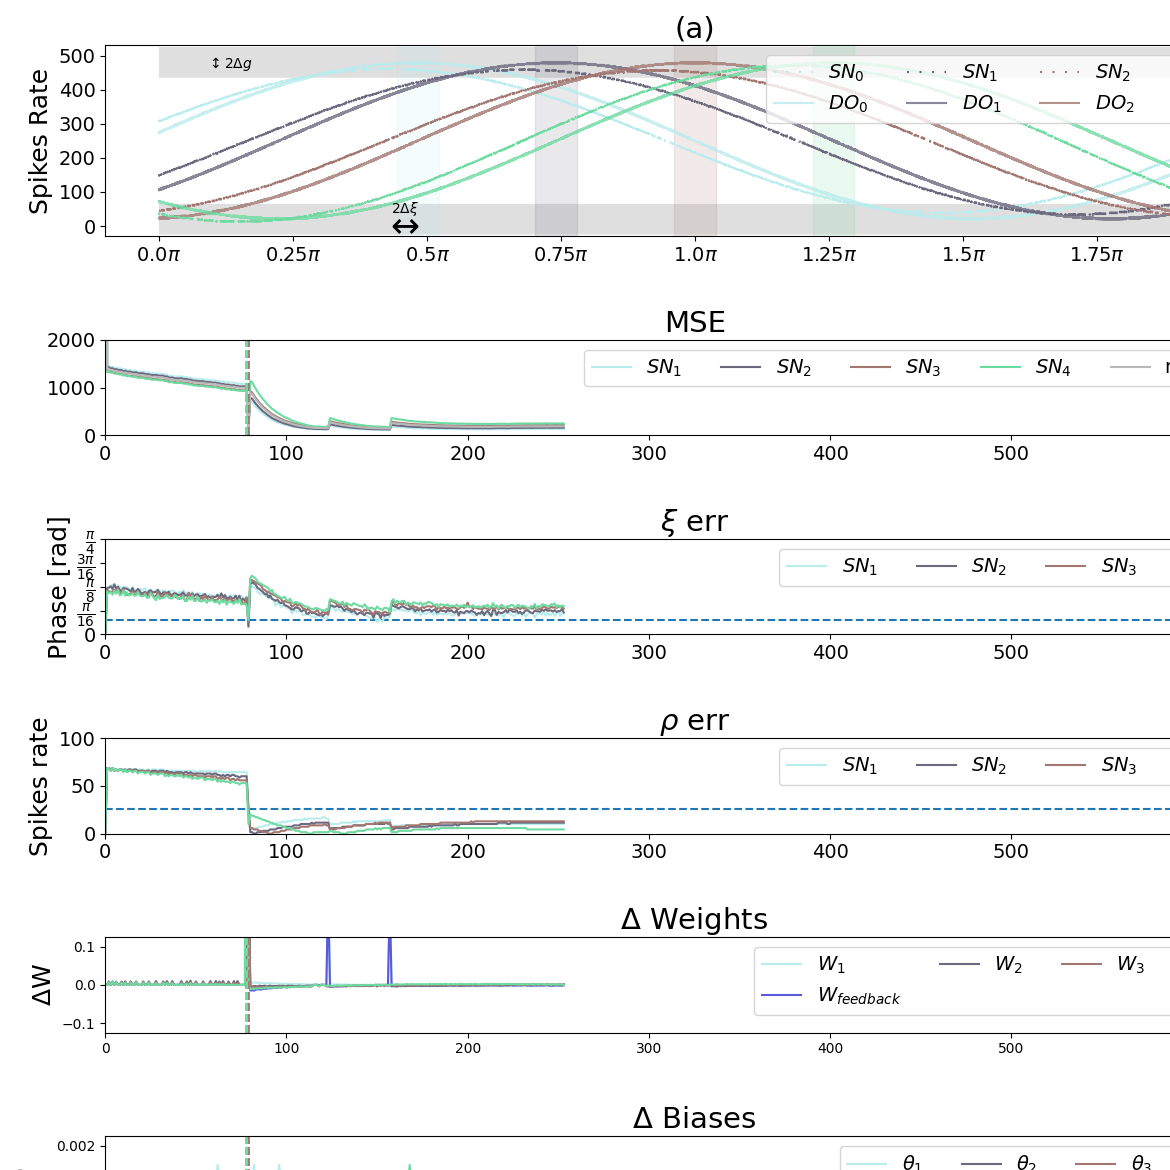

254it [1:16:44, 18.13s/it]


KeyboardInterrupt: 

In [8]:
%matplotlib notebook
from tqdm import tqdm

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

def_color = '#B8B8B8'
colors = ['#b9eced', '#6c697e', '#a27771', '#6ddaa0']
epochs = 650
title_fontsize = 21
label_fontsize = 18
tick_fontsize = 14

phase_axs = 0
mse_axs = 1
phase_gt_ratio_axs = 2
amplitude_gt_ratio_axs = 3
delta_weights_axs = 4
delta_biases_axs = 5

heights_ratios = np.ones(6)
heights_ratios[0] = 2
fig, axs = plt.subplots(len(heights_ratios), 1, figsize=(13, 13), gridspec_kw={'height_ratios': heights_ratios})

# mse_axs = 0
# phase_gt_ratio_axs = 1
# amplitude_gt_ratio_axs = 2
# delta_weights_axs = 3
# delta_biases_axs = 4

# heights_ratios = np.ones(5)
# fig, axs = plt.subplots(len(heights_ratios), 1, figsize=(13, 13), gridspec_kw={'height_ratios': heights_ratios})

weights = np.zeros((epochs+1, 5))
weights[0, :] = flat_weights(resonator)

biases = np.zeros((epochs+1, 4))
biases[0, :] = flat_thetas(resonator)

mses = np.ones((epochs+1, 5)) * np.inf
mses[0, :4] = np.array([(gt**2).mean() for gt in ground_truth])
mses[0, 4] = mses[0, :4].mean()
min_mse = mses[0, 4]

stdp_amplitude = np.ones((epochs+1, 4)) * np.inf
stdp_amplitude[0, :] = np.array([lr.A for lr in learning_rules])
amplitude_ratio = np.zeros((epochs+1, 4))

stdp_tau = np.ones((epochs+1, 4)) * np.inf
stdp_tau[0, :] = np.array([lr.tau for lr in learning_rules])


phase_ratio = np.zeros((epochs+1, 4))

y_epsilon = spikes_window * 0.036
x_epsilon = len(rresonator_input) * 7 / 360

gt_peaks = [argmax(gt) for gt in rolling_gt]
x_phase = np.linspace(0, 360, len(rresonator_input))


axs[phase_axs].set_ylim(gt_wave_amplitudes[0][1] - spikes_window * 0.04, gt_wave_amplitudes[0][0] + spikes_window * 0.04)
axs[phase_axs].set_xticks([])
axs[phase_axs].fill_between(x_phase, gt_wave_amplitudes[0][0] - y_epsilon, gt_wave_amplitudes[0][0] + y_epsilon, facecolor=def_color, alpha=0.45)
axs[phase_axs].fill_between(x_phase, gt_wave_amplitudes[0][1] - y_epsilon, gt_wave_amplitudes[0][1] + y_epsilon, facecolor=def_color, alpha=0.45)

axs[phase_axs].set_xlabel('Phase [rad]', fontsize=15)
axs[phase_axs].set_xlabel(' ', fontsize=label_fontsize)
axs[phase_axs].set_title('(a)', fontsize=title_fontsize)
axs[phase_axs].set_ylabel('Spikes Rate', fontsize=label_fontsize)
yticks = np.linspace(150, 350, 6)
yticks_labels = [0, 100, 200, 300, 400, 500]
axs[phase_axs].set_yticks(yticks)
axs[phase_axs].set_yticklabels(yticks_labels, fontsize=tick_fontsize)

xticks = np.linspace(0, 360, 9)
xtick_labels = [f'{round(t/180, 2)}' + r'$\pi$' for t in xticks]
axs[phase_axs].set_xticks(xticks)
axs[phase_axs].set_xticklabels(xtick_labels, fontsize=tick_fontsize)

phase_lines = []
for i in range(4):
    gt = rolling_gt[i]
    phase_lines.append(axs[phase_axs].plot(np.linspace(0, 360, len(gt)), gt, label=r'$SN_{i}$'.format(i=i), color=colors[i], linestyle='--', dashes=(1, 5))[0])
    axs[phase_axs].plot(np.linspace(0, 360, len(gt)), gt, color=colors[i], label=r'$DO_{i}$'.format(i=i), alpha=.8)[0]

norm = 360 / len(rresonator_input)
[axs[phase_axs].axvspan((peak - x_epsilon)*norm, (peak + x_epsilon)*norm, alpha=0.15, color=colors[i]) for i, peak in enumerate(gt_peaks)]
axs[phase_axs].text(16, 335, r'$\updownarrow 2\Delta g$', color='k', weight='bold')
axs[phase_axs].text(78, 165, r'$2\Delta\xi$', color='k', weight='bold')
axs[phase_axs].text(75.5, 140, r'$\leftrightarrow$', color='k',fontsize=25)


axs[mse_axs].set_title('MSE', fontsize=title_fontsize)
axs[mse_axs].set_xlim(0, epochs+1)
axs[mse_axs].set_ylim(0, 2000)
axs[mse_axs].tick_params(axis='x', labelsize=tick_fontsize)
axs[mse_axs].tick_params(axis='y', labelsize=tick_fontsize)
mse_lines = [axs[mse_axs].plot([mse], label=r'$SN_{i}$'.format(i=i+1) if i < 4 else 'mean mse', color=color)[0]
             for i, (color, mse) in enumerate(zip(colors + [def_color], mses[0]))]

axs[amplitude_gt_ratio_axs].set_title(r'$\rho$ err', fontsize=title_fontsize)
axs[amplitude_gt_ratio_axs].set_xlim(0, epochs+1)
axs[amplitude_gt_ratio_axs].set_ylabel('Spikes rate', fontsize=label_fontsize)
axs[amplitude_gt_ratio_axs].axhline(y_epsilon * 500/350, 0, 500, linestyle='--')
axs[amplitude_gt_ratio_axs].set_ylim(0, 100)
axs[amplitude_gt_ratio_axs].tick_params(axis='y', labelsize=tick_fontsize)
axs[amplitude_gt_ratio_axs].tick_params(axis='x', labelsize=tick_fontsize)
ampl_ratio_lines = [axs[amplitude_gt_ratio_axs].plot([w], label=r'$SN_{i}$'.format(i=i+1), color=colors[i])[0] for i, w in enumerate(amplitude_ratio[0])]

axs[phase_gt_ratio_axs].set_title(r'$\xi$ err ', fontsize=title_fontsize)
axs[phase_gt_ratio_axs].set_xlim(0, epochs+1)
axs[phase_gt_ratio_axs].set_ylabel('Phase [rad]', fontsize=label_fontsize)
axs[phase_gt_ratio_axs].axhline(x_epsilon * norm * np.pi / 180, 0, 500, linestyle='--')
axs[phase_gt_ratio_axs].set_ylim(0, np.pi/4)
# yticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
# ytick_labels = [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$']
yticks = [0, np.pi/16, np.pi/8, 3*np.pi/16, np.pi/4]
ytick_labels = [r'$0$', r'$\frac{\pi}{16}$', r'$\frac{\pi}{8}$', r'$\frac{3\pi}{16}$', r'$\frac{\pi}{4}$']
axs[phase_gt_ratio_axs].set_yticks(yticks)
axs[phase_gt_ratio_axs].set_yticklabels(ytick_labels, fontsize=tick_fontsize)
axs[phase_gt_ratio_axs].tick_params(axis='x', labelsize=tick_fontsize)
phase_ratio_lines = [axs[phase_gt_ratio_axs].plot([w], label=r'$SN_{i}$'.format(i=i+1), color=colors[i])[0] for i, w in enumerate(phase_ratio[0])]

axs[delta_weights_axs].set_title(r'$\Delta$ Weights ', fontsize=title_fontsize)
axs[delta_weights_axs].set_xlim(0, epochs+1)
axs[delta_weights_axs].set_ylabel(r'$\Delta$W', fontsize=label_fontsize)
axs[delta_weights_axs].set_ylim(-0.125, 0.125)
w_labels = [r'$W_1$', r'$W_{feedback}$', r'$W_2$', r'$W_3$', r'$W_4$']
w_colors = [colors[0]] + ['#5959DA'] + colors[1:]
weights_lines = [axs[delta_weights_axs].plot([w], label=l, color=c)[0] for i, (w, (l , c)) in enumerate(zip(weights[0], zip(w_labels, w_colors)))]

axs[delta_biases_axs].set_title(r'$\Delta$ Biases ', fontsize=title_fontsize)
axs[delta_biases_axs].set_xlim(0, epochs+1)
axs[delta_biases_axs].set_ylabel(r'$\Delta$$\theta$', fontsize=label_fontsize)
axs[delta_biases_axs].set_xlabel('Epoch', fontsize=label_fontsize)
axs[delta_biases_axs].set_ylim(-0.0025, 0.0025)
biases_lines = [axs[delta_biases_axs].plot([b], label=r'$\theta_{i}$'.format(i=i+1), color=colors[i])[0] for i, b in enumerate(biases[0])]



fig.tight_layout()

areas_sns = [[],[],[],[]] 
start_sns = [-1] * 4
momentum = [0] * 4
max_theta = -0.75
tuned_parameters = 0
count_after_tune = -1
with tqdm() as pbar:
    i = 1
    while count_after_tune != 0 and i < 550:
        count_after_tune -= 1
        run_with_stdp = True
        tuned_parameters = 0
        for neuron in resonator.neurons:
            neuron.membrane_potential = 0
            neuron.log_rand_gauss_var = 0
        resonator.forget_logs()
        resonator.input_full_data(sine_wave)

        # mse
        output = [events_to_spikes(neuron_output(neuron, freq0)-resonator_input[0],
                                   run_window=spikes_window,
                                   spikes_arr_size=int(clk_freq/freq0)+1)
                  for neuron in resonator.neurons[1:]]
        max_y = 0
        mses[i, :4] = [((gt - o)**2).mean() for gt, o in zip(rolling_gt, output)]
        mses[i, 4] = mses[i, :4].mean()
        if mses[i, 4] < min_mse:
            min_mse = mses[i, 4]
            run_with_stdp = False
        for j, line in enumerate(mse_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(mses[:i, j])
            max_y = np.max([max_y, 1.5*mses[max(0, i-4):i+1, j].max()])
        for j, sns in enumerate(start_sns):
            if sns != -1:
                axs[mse_axs].axvline(sns, color=colors[j], linestyle='--')
                axs[delta_weights_axs].axvline(sns, color=colors[j], linestyle='--')
                axs[delta_biases_axs].axvline(sns, color=colors[j], linestyle='--')

        # phase chart
        for j, o in enumerate(output):
            phase_lines[j].set_ydata(o)

        # stdp charts:
        for j, lr in enumerate(learning_rules):
            stdp_amplitude[i, j] = lr.A
            stdp_tau[i, j] = lr.tau

        thetas_shift = [-.2*(((2*np.mean(o) - spikes_window)/spikes_window)**2)*np.sign(np.mean(o)-spikes_window/2) for o in output]
        for j, neuron in enumerate(resonator.neurons[1:]):
            bs = thetas_shift[j]
            momentum[j] = bs + momentum_beta * momentum[j]
            neuron.theta += momentum[j]
            if neuron.theta > max_theta:
                neuron.theta = max_theta

                
        weights[i, :] = flat_weights(resonator)
        delta_weights = weights[1:, :] - weights[:-1, :]
        biases[i, :] = flat_thetas(resonator)
        delta_biases = biases[1:, :] - biases[:-1, :]
        delta_biases[i-1, :] = 0
        peaks = [argmax(o)for o in output]
        # activate weights learning
        for j, o in enumerate(output):
            dc = o.mean()
            o_max = o.max()
            o_min = o.min()
            neuron = resonator.neurons[1+j]
            # first 2 conditions to check if the amplitude is on the right place.
            # next condition is to check if the peak is in the right place.
            o_argmax = argmax(o)

            if (abs(o_argmax - gt_peaks[j]) <= 2*x_epsilon and
                abs(o_max - gt_wave_amplitudes[j][0]) > y_epsilon/2 and
                abs(o_min - gt_wave_amplitudes[j][1]) > y_epsilon/2
               ):
                if start_sns[j] == -1:
                    start_sns[j] = i
                areas_j = areas_sns[j]
                if areas_j == [] or len(areas_j[-1]) == 2:
                    areas_j.append((i, ))
                stretch_or_shrink_scale = (mses[i, j]*1000//1e3) / 1e3
                if gt_wave_amplitudes[j][1] < o_min < o_max < gt_wave_amplitudes[j][0]:
                    neuron.theta -= stretch_or_shrink_scale
                    neuron.synapses_weights[0] += 2 * stretch_or_shrink_scale
                    if j == 0:
                        neuron.synapses_weights[1] -= 2 * stretch_or_shrink_scale
                elif o_min < gt_wave_amplitudes[j][1] < gt_wave_amplitudes[j][0] < o_max:
                    stretch_or_shrink_scale *= 2
                    neuron.theta += stretch_or_shrink_scale
                    neuron.synapses_weights[0] -= 2 * stretch_or_shrink_scale #/ len(neuron.synapses_weights)
                    if j == 0:
                        neuron.synapses_weights[1] += 2 * stretch_or_shrink_scale  # / len(neuron.synapses_weights)
            else:
                areas_j = areas_sns[j]
                if areas_j != [] and len(areas_j[-1]) == 1:
                    areas_j[-1] = (areas_j[-1][0], i)
                    
            if abs(o_argmax - gt_peaks[j]) <= x_epsilon:
                tuned_parameters += 1
            if (abs(o_max - gt_wave_amplitudes[j][0]) <= y_epsilon
            ):
                tuned_parameters += 1

            phase_diff_ratio = abs(peaks[j] - gt_peaks[j])                                   # number between 0 - 1 represent [0 - 180]
            if not run_with_stdp:
                neuron.supervised_stdp = None
                amplitude_ratio[i, j] = amplitude_ratio[i-1, j]
                phase_ratio[i, j] = phase_ratio[i-1, j]
            else:
                wave_amplitude = o_max - o_min
                gt_wave_amplitude = gt_wave_amplitudes[j][0] - gt_wave_amplitudes[j][1]
                wave_amplitude_ratio = abs((wave_amplitude - gt_wave_amplitude)/gt_wave_amplitude)        # number between 0 - 1 represent [0 - gt_wave_amplitude]
                neuron.supervised_stdp = learning_rules[j]
                neuron.supervised_stdp.A = (1 + wave_amplitude_ratio) * 10e-6
                neuron.supervised_stdp.tau = clk_freq / freq0 * (5/180 + abs(peaks[j] - gt_peaks[j]) / len(o))     

            amplitude_ratio[i, j] = abs((o_max - gt_wave_amplitudes[j][0]))
            ampl_ratio_lines[j].set_xdata(np.arange(i))
            ampl_ratio_lines[j].set_ydata(amplitude_ratio[:i, j] * 500/350)

            phase_ratio[i, j] = (phase_diff_ratio * norm * np.pi / 180)%(np.pi)
            phase_ratio_lines[j].set_xdata(np.arange(i))
            phase_ratio_lines[j].set_ydata(phase_ratio[:i, j])
        

        for j, line in enumerate(weights_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(delta_weights[:i, j])
            
        for j, line in enumerate(biases_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(delta_biases[:i, j])

        wave_amplitudes = [(o.max(), o.min()) for o in output]
#         pbar.set_postfix({'weights': flat_weights(resonator).tolist(), 'thetas': flat_thetas(resonator), 'mse': mses[i, :].mean(),
#                           'amplitudes': wave_amplitudes, 'dc': [o.mean() for o in output], 'tuned_parameters': tuned_parameters})

         
        for j in range(len(heights_ratios)):
            axs[j].legend(loc='upper right',  ncol=5 if j == mse_axs else 4, fontsize=14)

        fig.canvas.draw()
        fig.canvas.flush_events()

        pbar.update(1)
        i = (i+1) % epochs
        if i == 0:
            i = 1
        
        if tuned_parameters == 8 and count_after_tune < 0:
            count_after_tune = 1
            print('tune')
            print('mse', list(mses[i-1]))


delta_bias_mask = np.zeros_like(delta_biases)
for j, areas in enumerate(areas_sns):
    for area in areas:
        a0 = area[0]
        a1 = i
        if len(area) == 2:
            a1 = area[1]
        alph = .15
        if a0%100 == 5:
            alph = 1
        axs[mse_axs].fill_between(np.arange(a0, a1+1), 0, 2000, facecolor=colors[j], alpha=alph)
        axs[delta_weights_axs].fill_between(np.arange(a0, a1+1), -2000, 2000, facecolor=colors[j], alpha=alph)
        axs[delta_biases_axs].fill_between(np.arange(a0, a1+1), -2000, 2000, facecolor=colors[j], alpha=alph)
        delta_bias_mask[a0-1:a1, j] = 1

delta_biases *= delta_bias_mask

for j, line in enumerate(biases_lines):
    line.set_xdata(np.arange(i))
    line.set_ydata(delta_biases[:i, j])

fig.tight_layout()